## Анализ графа

В данном файле будет анализ графа. Для начала, надо бы построить граф:

In [31]:
import requests
import os
from bs4 import BeautifulSoup
import copy
import sys


html_to_url = dict()
url_to_html = dict()

with open('urls.txt', 'r') as f:
    lines = f.read().split('\n')
    for line in lines:
        elems = line.split('\t')
        html_to_url[elems[0]] = elems[1]
        url_to_html[elems[1]] = elems[0] 

In [32]:
adj_list_out = dict()
adj_list_in = dict()
depths = dict()
link_list = list()
new_link_list = list()
unique_links = set()

path = html_to_url['1.html']
link_list.append(path)
depth = 1
count = 0
while True:
    for path in link_list:
        count += 1
        sys.stdout.write("\rProcessing {0}".format(count))
        depths[path] = depth
        f = open('docs/' + url_to_html[path], 'r')
        soup = BeautifulSoup(f, 'lxml')
        f.close()
        urls = [x.get('href') for x in soup.findAll('a')]
        for link in ['https://simple.wikipedia.org' + x for x in urls if x and x[0] == '/' and len(x) > 1 and x[1] != '/']:
            if url_to_html.get(link) is not None:
                if adj_list_out.get(path) == None:
                    adj_list_out[path] = [link]
                else:
                    adj_list_out[path].append(link)
                if adj_list_in.get(link) == None:
                    adj_list_in[link] = [path]
                else:
                    adj_list_in[link].append(path)
                if link not in unique_links:
                    unique_links.add(link)
                    new_link_list.append(link)
    if len(new_link_list) == 0:
        break
    link_list = copy.copy(new_link_list)
    depth += 1
    new_link_list = []

Processing 171372

In [51]:
for key in depths:
    depths[key] -= 1

Попутно мы собрали немного статистики: в depths лежат глубины при обходе в ширину. В adj_list_in и adj_list_out лежат входящие и выходящие ребра соответственно. Построим гистограмму по глубинам:

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

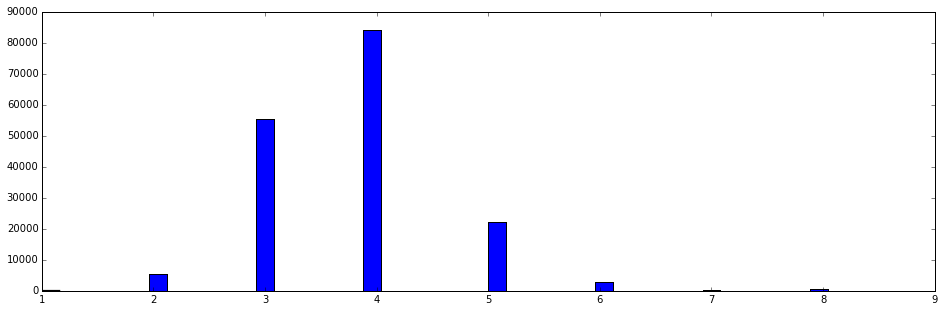

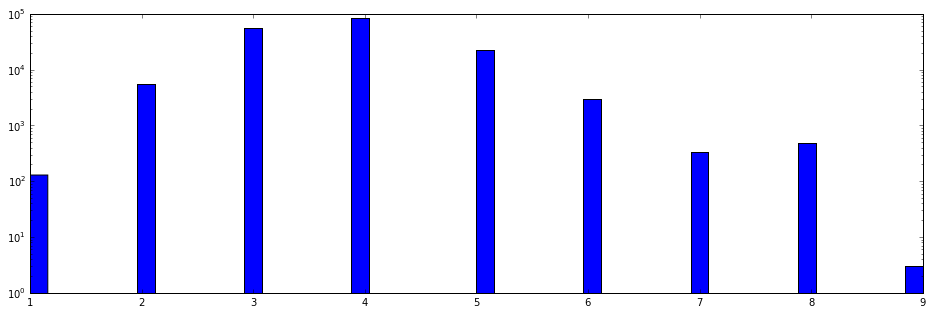

9


In [53]:
depth_values = depths.values()
num_bins = 50
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(depth_values, num_bins, facecolor='blue')
plt.show()

plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(depth_values, num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()
print max(depth_values)

Сверху приведена гистограмма с абсолютной и логарифмической шкалами. Так более информативно. Теперь займемся анализом **in степеней вершин**:

In [64]:
amount_in = dict()
amount_out = dict()

for key, value in adj_list_in.items():
    amount_in[key] = len(value)
for key, value in adj_list_out.items():
    amount_out[key] = len(value)

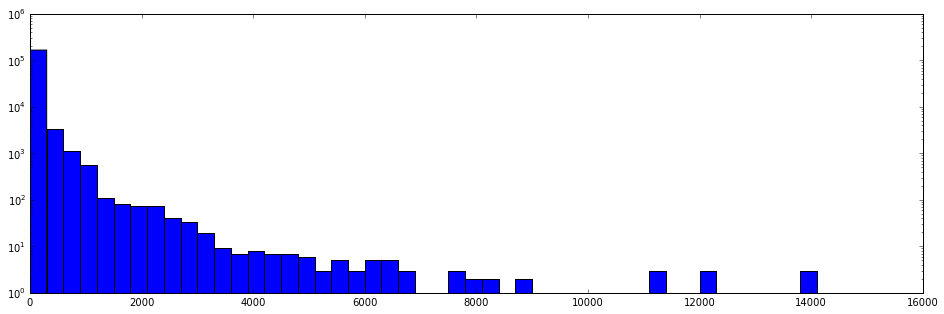

In [126]:
num_bins = 50
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(amount_in.values(), num_bins, facecolor='blue', range = (0, 15000))
plt.yscale('log', nonposy = 'clip')
plt.show()

In [79]:
import operator
sorted_amount_in = sorted(amount_in.items(), key=operator.itemgetter(1), reverse = True)

In [80]:
for url, amount in sorted_amount_in[:10]:
    print '{0}   {1}'.format(url, amount)

https://simple.wikipedia.org/wiki/Main_Page   342947
https://simple.wikipedia.org/wiki/United_States   35956
https://simple.wikipedia.org/wiki/Multimedia   29222
https://simple.wikipedia.org/wiki/France   23047
https://simple.wikipedia.org/wiki/Category:Living_people   17618
https://simple.wikipedia.org/wiki/International_Standard_Book_Number   17452
https://simple.wikipedia.org/wiki/Category:People_stubs   15227
https://simple.wikipedia.org/wiki/Germany   14951
https://simple.wikipedia.org/wiki/Category:France_geography_stubs   14156
https://simple.wikipedia.org/wiki/United_Kingdom   14043


Как видно, встречаются ссылки типа **Category**. По идее, это страницы со ссылками, не являющиеся статьями. Но для построения графа они важны, поэтому я их оставил. Теперь анализ **out степеней**:

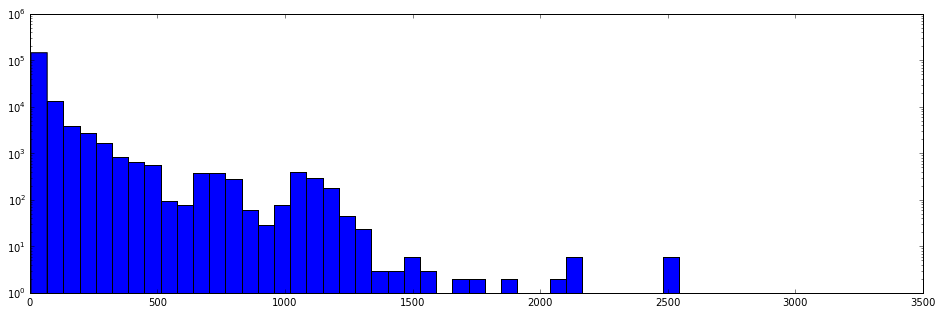

In [85]:
num_bins = 50
plt.figure(figsize = (16,5))
n, bins, patches = plt.hist(amount_out.values(), num_bins, facecolor='blue')
plt.yscale('log', nonposy = 'clip')
plt.show()

In [86]:
sorted_amount_out = sorted(amount_out.items(), key=operator.itemgetter(1), reverse = True)

In [89]:
for url, amount in sorted_amount_out[:10]:
    print '{0}   {1}'.format(url, amount)

https://simple.wikipedia.org/wiki/Deaths_in_2013   3181
https://simple.wikipedia.org/wiki/Deaths_in_January_2012   2488
https://simple.wikipedia.org/wiki/Deaths_in_February_2012   2488
https://simple.wikipedia.org/wiki/Deaths_in_March_2012   2488
https://simple.wikipedia.org/wiki/Deaths_in_2012   2488
https://simple.wikipedia.org/wiki/Deaths_in_April_2012   2488
https://simple.wikipedia.org/wiki/Deaths_in_May_2012   2488
https://simple.wikipedia.org/wiki/List_of_Medal_of_Honor_recipients_for_World_War_II   2160
https://simple.wikipedia.org/wiki/2006_in_movies   2135
https://simple.wikipedia.org/wiki/2006_in_film   2135


**Интересно**: Заметим, что со 2-го по 7-е место числа одинаковые. Это потому, что ссылки на самом деле одинаковые и все выходящие ребра повторяются. Такие вещи мы будем находить во втором задании. Теперь посчитаем **Page Rank**:

In [115]:
amount_of_documents = len(os.listdir('docs'))
amount_of_documents_without_cat = len(os.listdir('txt_docs'))

In [116]:
import copy

damping_factor = 0.85

empty_graph = dict()
prev_graph = dict()
current_graph = dict()
for key in adj_list_out.keys():
    empty_graph[key] = (1 - damping_factor) / amount_of_documents
    current_graph[key] = 1 / amount_of_documents
    prev_graph[key] = 1

In [117]:
amount_of_iterations = 100

for i in xrange(amount_of_iterations):
    sys.stdout.write("\rProcessing {0}".format(i))
    for key, value in adj_list_out.items():
        weight = damping_factor * float(prev_graph[key]) / len(value)
        for elem in value:
            current_graph[elem] += weight
    prev_graph = copy.copy(current_graph)
    current_graph = copy.copy(empty_graph)

Processing 99

In [118]:
graph = copy.copy(prev_graph)

In [119]:
sorted_page_rank = sorted(graph.items(), key=operator.itemgetter(1), reverse = True)

In [120]:
for url, page_rank in sorted_page_rank[:20]:
    print '{0}   {1}'.format(url, page_rank)

https://simple.wikipedia.org/wiki/Main_Page   0.0569189798558
https://simple.wikipedia.org/wiki/Multimedia   0.00543725290564
https://simple.wikipedia.org/wiki/United_States   0.00386158705006
https://simple.wikipedia.org/wiki/Category:Stubs   0.00226302510782
https://simple.wikipedia.org/wiki/Category:Geography_stubs   0.0022450975919
https://simple.wikipedia.org/wiki/United_Kingdom   0.00190445104874
https://simple.wikipedia.org/wiki/International_Standard_Book_Number   0.00172751495906
https://simple.wikipedia.org/wiki/Category:Technology_stubs   0.00170271930905
https://simple.wikipedia.org/wiki/France   0.00168571668659
https://simple.wikipedia.org/wiki/Category:People_stubs   0.00161654809608
https://simple.wikipedia.org/wiki/Category:Music_stubs   0.00156174338675
https://simple.wikipedia.org/wiki/Category:Europe_stubs   0.00132814971295
https://simple.wikipedia.org/wiki/Category:Biology_stubs   0.00132269545345
https://simple.wikipedia.org/wiki/Canada   0.0012774244499
https://

Как видно, страницы-категории в топе по Page Rank. Можно их не учитывать. Тогда получаются такие результаты:

In [121]:
damping_factor = 0.85

empty_graph = dict()
prev_graph = dict()
current_graph = dict()
for key in adj_list_out.keys():
    empty_graph[key] = (1 - damping_factor) / amount_of_documents_without_cat
    current_graph[key] = 1 / amount_of_documents_without_cat
    prev_graph[key] = 1

In [122]:
amount_of_iterations = 100

for i in xrange(amount_of_iterations):
    sys.stdout.write("\rProcessing {0}".format(i))
    for key, value in adj_list_out.items():
        if 'Category:' in key:
            continue
        weight = damping_factor * float(prev_graph[key])
        counter = 0
        for elem in value:
            if 'Category:' not in elem:
                counter += 1
        
        if counter != 0:
            weight = weight / counter
        for elem in value:
            if 'Category:' not in elem:
                current_graph[elem] += weight
            
    prev_graph = copy.copy(current_graph)
    current_graph = copy.copy(empty_graph)

Processing 99

In [123]:
graph = copy.copy(prev_graph)

In [124]:
sorted_page_rank = sorted(graph.items(), key=operator.itemgetter(1), reverse = True)

In [125]:
for url, page_rank in sorted_page_rank[:20]:
    print '{0}   {1}'.format(url, page_rank)

https://simple.wikipedia.org/wiki/Main_Page   0.0657119457636
https://simple.wikipedia.org/wiki/United_States   0.00502085770727
https://simple.wikipedia.org/wiki/Multimedia   0.00449821506464
https://simple.wikipedia.org/wiki/United_Kingdom   0.00253175153131
https://simple.wikipedia.org/wiki/International_Standard_Book_Number   0.00224984793048
https://simple.wikipedia.org/wiki/France   0.00222964125044
https://simple.wikipedia.org/wiki/Definition   0.00187662335594
https://simple.wikipedia.org/wiki/Country   0.00178543063521
https://simple.wikipedia.org/wiki/Canada   0.0016128957149
https://simple.wikipedia.org/wiki/English_language   0.00158758396004
https://simple.wikipedia.org/wiki/England   0.001440991184
https://simple.wikipedia.org/wiki/Europe   0.00141760377741
https://simple.wikipedia.org/wiki/Germany   0.00140043968244
https://simple.wikipedia.org/wiki/Japan   0.00136592288026
https://simple.wikipedia.org/wiki/Music   0.00128941321243
https://simple.wikipedia.org/wiki/Gover

Что можно сказать - наличие или отсутствие Category не особо повлияло на порядок остальных страниц. Хотя некоторые перестановки все же есть. И с огромным отрывом лидирует главная страница, что естественно. 